# Part 1 - Exploratory Data Analysis

## Import Packages and Data

Import relevant packages

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas_profiling
from scipy import stats
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose


Import datasets as pandas dataframe and view data, added a volume column to provide a count for aggregation

In [2]:
logins = pd.read_json('logins.json')
logins['Volume'] = 1
logins.head()

,login_time,Volume
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [3]:
rides = pd.read_json('ultimate_data_challenge.json')
rides.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


Looking at the dataset shows ~93,000 logins recorded. The datatype is datetime, which is what we want. There are no null values.

In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
 1   Volume      93142 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 MB


In [5]:
logins.isna().sum()

login_time    0
Volume        0
dtype: int64

Looking at the dataset shows ~93,000 logins recorded. The datatype is datetime, which is what we want. There are no null values.

Aggregate logins into 15 minute bins

In [6]:
logins = logins.set_index('login_time')
logins = logins.resample('15min').sum()

In [7]:
logins.head()

,Volume
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [8]:
logins.describe()

,Volume
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


The volume column shows the aggregated volume in 15min increments. Calling describe gives us an idea of ranges of logins per time bin.

## Plot time series to see cycles

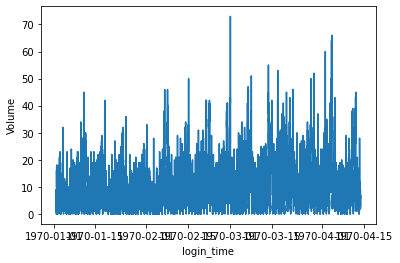

In [9]:
axs = sns.lineplot('login_time', 'Volume', data=logins)

Resample to 1 day to remove the minute to minute chatter and see the pattern over time easier

In [10]:
logins_day = logins.resample('D').sum()

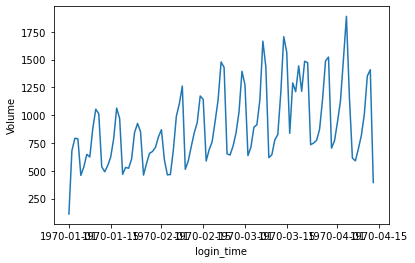

In [11]:
axs = sns.lineplot('login_time', 'Volume', data=logins_day)

Decompose the data to pull out the daily trend

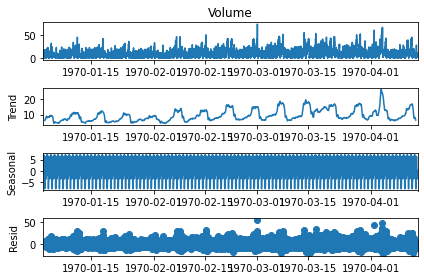

In [12]:
logins_decomposed = seasonal_decompose(logins['Volume'], freq=96)
figure = logins_decomposed.plot()
plt.show()

freq parameter picked from https://gist.github.com/balzer82/5cec6ad7adc1b550e7ee

## Analysis of login data

You can see in both the 1 day aggregated data and the daily decomposed trend that the demand increased over time during this sample of data. There is a large drop off at the end of the dataset, this could be due to a holiday or world event. (Although the data is simulated it could be interesting to look at world event/holidays. In 1970 Easter was on March 29th, Paul McCartney left the Beatles on April 10th, and Apollo 13 had its explotion on April 13th.)

# Part 2 - Experiment and Metrics Design

## What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The key measure of success in this situation is profit growth. It would need to be shown that the additional revenue from having more driver flexibility is greater than the cost of reimbursing all toll costs.

## Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.

A way of testing the effectiveness of reimbursing driver partners for toll fees in order for them to be able to service both cities would be to perform an A/B test. The drivers would be split into 2 groups randomly. One group would continue to operate normally in their preferred areas and the other group would be told that Ultimate will start reimbursing toll fees. They drivers in the 2nd group would need to be informed otherwise they won't change their behavior. Since the different cites have different active periods the test would have to last longer than a day. A good length of time would be a week long period. This is long enough to capture a weekly cycle, but short enough that it can be repeated and compared. The experiment replication would prevent false positive results and ensure the company leadership is making an informed decision. 

The best way to test the results is by hypothesis testing. The null hypothesis would be that making the change and paying for tolls does not increase profit. If the increase in profit falls outside of the expected 95% confidence interval, especially for mulitiple iterations of the experiment, it would reject the null hypothesis and suggest that paying tolls in order to increase driver availability is a profitable change to make. 

# Part 3 - Predictive Modeling

## Finding fraction of retained users

In [13]:
rides = pd.read_json('ultimate_data_challenge.json')
rides.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Several columns have null values, these will need to be filled in. The ave rating columns can be filled with median. Phone type will have to be labeled as unknown. Signup date and last trip date will need to be switched to datetime format.

In [15]:
rides['avg_rating_of_driver'].median()

4.9

In [16]:
rides['avg_rating_by_driver'].median()

5.0

In [17]:
rides['avg_rating_of_driver'] = rides['avg_rating_of_driver'].fillna(4.9)
rides['avg_rating_by_driver'] = rides['avg_rating_by_driver'].fillna(5.0)
rides['signup_date'] = pd.to_datetime(rides['signup_date'])
rides['last_trip_date'] = pd.to_datetime(rides['last_trip_date'])
rides['phone'] = rides['phone'].fillna('Unknown')

In [18]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Create column for time since last trip assuming the maximum last_trip_date is the date the data was pulled, then column to designate yes or no for if they were considered retained

In [19]:
max(rides['last_trip_date'])

Timestamp('2014-07-01 00:00:00')

In [20]:
rides['temp'] = '2014-07-01'
rides['temp'] = pd.to_datetime(rides['temp'])
rides['days_since_last_trip'] = rides['temp'] - rides['last_trip_date']
rides = rides.drop(['temp'], axis=1)
rides.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,days_since_last_trip
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000
mean,2.278200,4.650038,1.074764,8.849536,60.926084,5.796827,4.779050,72 days 15:57:55.008000
std,3.792684,0.575601,0.222336,19.958811,37.081503,5.707357,0.445974,61 days 17:15:20.288309375
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0 days 00:00:00
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000,13 days 00:00:00
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,54 days 00:00:00
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,137 days 00:00:00
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,181 days 00:00:00


In [21]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   city                    50000 non-null  object         
 1   trips_in_first_30_days  50000 non-null  int64          
 2   signup_date             50000 non-null  datetime64[ns] 
 3   avg_rating_of_driver    50000 non-null  float64        
 4   avg_surge               50000 non-null  float64        
 5   last_trip_date          50000 non-null  datetime64[ns] 
 6   phone                   50000 non-null  object         
 7   surge_pct               50000 non-null  float64        
 8   ultimate_black_user     50000 non-null  bool           
 9   weekday_pct             50000 non-null  float64        
 10  avg_dist                50000 non-null  float64        
 11  avg_rating_by_driver    50000 non-null  float64        
 12  days_since_last_trip    50000 no

In [22]:
rides['retained'] = np.where(rides['days_since_last_trip'] <= pd.Timedelta(30, unit='d')  , 'yes', 'no')

code modified from: https://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column
https://www.titanwolf.org/Network/q/b0681cbd-ebbf-405e-93bd-5a7fd1aaff51/y

In [23]:
rides.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_since_last_trip,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14 days,yes
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57 days,no
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175 days,no
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2 days,yes
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108 days,no


In [24]:
ratio = sum(rides['retained'] == 'yes') / 50000
print(ratio)

0.37608


37.608% of observed users were considered retained.

## Build Predictive Model

import relevant libraries

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import sklearn.metrics as metrics
import time

Clean up dataset, remove computed varables and rename retained to active, dates can be removed since they have been used to create the target variable and datetime variables confuse the classifier

In [28]:
rides = rides.drop(['days_since_last_trip'], axis=1)
rides = rides.rename(columns = {'retained':'active'})
rides = rides.drop(['signup_date', 'last_trip_date'], axis=1)

KeyError: "['days_since_last_trip'] not found in axis"

Create one hot encoding for several variables, city, phone, ultimate_black_user

In [29]:
rides_onehot = pd.get_dummies(rides, columns = ['city', 'phone', 'ultimate_black_user'])
rides_onehot.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,yes,0,1,0,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,no,1,0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,no,1,0,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,yes,0,1,0,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,no,0,0,1,1,0,0,1,0


Create X and y datasets and split into test/train sets

In [30]:
X = rides_onehot.drop(columns='active')
y = rides_onehot[['active']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)

Build extreme gradient boost classifier with random grid hyperparameter optimization (ran with and without scaling to see if there is a difference, usually no need to scale random forest classifiers but checking anyways). Using classification because the target variable is not continuous.

In [31]:
start = time.time()

#steps = [('scaler', StandardScaler()), ('xgbc', XGBClassifier())]
#pipe = Pipeline(steps)

n_estimators = [int(x) for x in np.linspace(start = 25, stop = 225, num = 25)]
max_depth = [1,2,3,4,5,6,7,8,9,10]
eta = [.001,.005,.01,.025,.05,.1,.2,.3]
subsample = [.25,.5,.75,1]
colsample_bytree = [.25,.5,.75,1]

random_grid = {'xgbc__n_estimators': n_estimators,
               'xgbc__max_depth': max_depth,
               'xgbc__eta': eta,
               'xgbc__subsample': subsample,
               'xgbc__colsample_bytree': colsample_bytree}

xgboost = RandomizedSearchCV(
        estimator=XGBClassifier(),
        param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)

grid_result = xgboost.fit(X_train, y_train)
best_params = xgboost.best_params_
print(best_params)
print('It takes %s minutes' % ((time.time() - start)/60))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[15:59:23] WARNING: ..\src\learner.cc:573: 
Parameters: { "xgbc__colsample_bytree", "xgbc__eta", "xgbc__max_depth", "xgbc__n_estimators", "xgbc__subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:59:23] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'xgbc__subsample': 0.75, 'xgbc__n_estimators': 133, 'xgbc__max_depth': 7, 'xgbc__eta': 0.3, 'xgbc__colsample_bytree': 0.75}
It takes 9.174215217431387 minutes


In [32]:
print("Accuracy score (training): {0:.3f}".format(xgboost.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(xgboost.score(X_test, y_test)))

Accuracy score (training): 0.838
Accuracy score (validation): 0.788


In [33]:
y_pred=xgboost.predict(X_test)

precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: [0.81375738 0.73708026]
recall: [0.85952411 0.66688214]
fscore: [0.83601485 0.70022624]


Using scaling changed the training/testing accuracy from 0.838/0.788 to 0.824/0.791, 0.3% increase in test accuracy but 21% increase in time. Extra compute time probably not worth the very small increase in performance.

Train model with best parameters and full dataset. We used 75% of the data to train the model, but once the optimal hyperparameters were found, it is best to use your full dataset to train the model before deploying to production for added accuracy. 

In [34]:
xgb = XGBClassifier(subsample = 0.75, n_estimators = 133, max_depth = 7, eta = 0.3, colsample_bytree = 0.75)
xgb.fit(X, y)

[15:59:28] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=133, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
print("Accuracy score (full data): {0:.3f}".format(xgb.score(X, y)))

Accuracy score (full data): 0.858


Refitting the optimal model with all of the data took very little time and had a 2% increase in accuracy

Finding most important features

In [36]:
importances = pd.DataFrame({
    'Feature': rides_onehot.drop('active', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
city_King's Landing,0.269973
avg_rating_by_driver,0.126695
phone_Android,0.116142
ultimate_black_user_False,0.073544
phone_iPhone,0.066129
city_Astapor,0.057825
weekday_pct,0.053683
surge_pct,0.049015
trips_in_first_30_days,0.037230


The largest influence by far (~27%) on whether a user is still active is if they are from the city of King's Landing. The next largest, but half as important, is the average rating given to the user by drivers. These 2 features account for over 39% of the influence on the results. 

Code modified from: https://www.kaggle.com/lucidlenn/data-analysis-and-classification-using-xgboost

## Discussion

The reason I went with the XGBClassifier for a predictive model is becasue it is one of the current fastest and most accurate classifiers out. It is also extremly scalable if more data becomes available. One of the main concerns I have about the model is that it only has data available from one month of signups. It would be much more informative if there was a few more months or even a full year of data. Maybe user retention is partially seasonal due changing weather and more people walk instead of taking a short trip. 

There are a few ways Ultimate could leverage these insights. They could increase marketing in Kings Landing since they know that anybody who signs up has a better chance of continuing to use the service. On the flip side, since they know these users are more loyal, they could decrease spending in Kings Landing and increase it in Astapor and Winterfell to try to boost usage and be less concentrated in one area. If any changes are made the analysis can be redone to see if the changes have created a positive effect. Another easy way to boost retention would be to encourage drivers to give high ratings to most of their riders. It seems if a rider feels appreciated they are more likely to continue to use the service. 